## Plots for Single Echo Results

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
from collections import defaultdict
import pandas
import json
import sys
import glob
import IPython.display as ipd
sys.path.append("..")
sys.path.append("../src")
from prepare_echo_dataset_pn import PN_PATTERNS_1024_8

In [2]:
echoes = ["clean", 50, 75, 76, 100]

## Rave Results
results_rave = {i:{dur:{} for dur in [5, 10, 30, 60]} for i in ["drums", "vocals", "other"]}
for key in results_rave.keys():
    for dur in results_rave[key].keys():
        for echo in echoes:
            results_rave[key][dur][echo] = {e:[] for e in echoes[1:]}
            for f in glob.glob(f"results/{key}_{echo}_dur{dur}_seed*.json"):
                res = json.load(open(f))
                for echo2 in echoes[1:]:
                    for tune, value in res.items():
                        if f"z_{echo2}" in value:
                            results_rave[key][dur][echo][echo2] += value[f"z_{echo2}"]


## DDSP Results
results_ddsp = {i:{dur:{} for dur in [5, 10, 30, 60]} for i in ["drums", "vocals", "other"]}
for key in results_ddsp.keys():
    for dur in results_ddsp[key].keys():
        for echo in echoes:
            results_ddsp[key][dur][echo] = {e:[] for e in echoes[1:]}
            for f in glob.glob(f"results/ddsp_{key}_{echo}_dur{dur}*.json"):
                res = json.load(open(f))
                for echo2 in echoes[1:]:
                    for tune, value in res.items():
                        if f"z_{echo2}" in value:
                            results_ddsp[key][dur][echo][echo2] += value[f"z_{echo2}"]

## Dance Diffusion Results
noise = 0.2
results_dd = {i:{dur:{} for dur in [5, 10, 30, 60]} for i in ["drums", "vocals", "other"]}
for key in results_dd.keys():
    for dur in results_dd[key].keys():
        for echo in echoes:
            results_dd[key][dur][echo] = {e:[] for e in echoes[1:]}


for key in results_dd.keys():
    for echo in echoes:
        for f in glob.glob(f"results/dd_{key}_{echo}_{noise}.json"):
            res = json.load(open(f))
            for echo2 in echoes[1:]:
                for v in res.values():
                    for dur in [5, 10, 30, 60]:
                        value = v[f"{dur}"]
                        if f"z_{echo2}" in value:
                            results_dd[key][dur][echo][echo2] += value[f"z_{echo2}"]

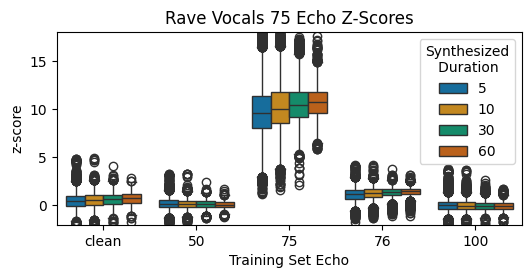

In [9]:
durstr = "Synthesized\n   Duration"
d = dict(dataset=[], z=np.array([]))
d[durstr] = []
for dataset in ["clean", 50, 75, 76, 100]:
    for dur in [5, 10, 30, 60]:
        t = results_rave["vocals"][dur][dataset][75]
        d["dataset"] += [dataset]*len(t)
        d["z"] = np.concatenate((d["z"], t))
        d[durstr] += [dur]*len(t)

fac = 0.5
plt.figure(figsize=(fac*12, fac*5))


sns.boxplot(data=pandas.DataFrame(data=d), x="dataset", y="z", hue=durstr, palette="colorblind")
plt.xlabel("Training Set Echo")
plt.ylabel("z-score")
plt.ylim([-2, 18])
plt.title("Rave Vocals 75 Echo Z-Scores")
plt.savefig("../Writeup/figs/RaveZScoreExamples.svg", bbox_inches='tight')

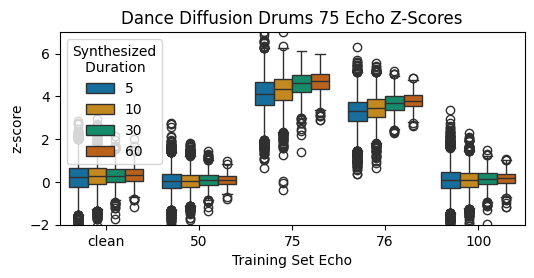

In [8]:
d = dict(dataset=[], z=np.array([]))
d[durstr] = []
for dataset in ["clean", 50, 75, 76, 100]:
    for dur in [5, 10, 30, 60]:
        t = results_dd["drums"][dur][dataset][75]
        d["dataset"] += [dataset]*len(t)
        d["z"] = np.concatenate((d["z"], t))
        d[durstr] += [dur]*len(t)

fac = 0.5
plt.figure(figsize=(fac*12, fac*5))


sns.boxplot(data=pandas.DataFrame(data=d), x="dataset", y="z", hue=durstr, palette="colorblind")
plt.xlabel("Training Set Echo")
plt.ylabel("z-score")
plt.ylim([-2, 7])
plt.title("Dance Diffusion Drums 75 Echo Z-Scores")
plt.savefig("../Writeup/figs/DanceDiffusionZScoreExamples.svg", bbox_inches='tight')

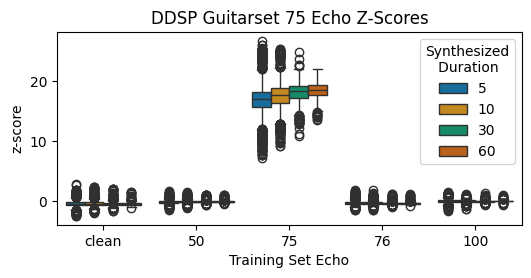

In [7]:
d = dict(dataset=[], z=np.array([]))
d[durstr] = []
for dataset in ["clean", 50, 75, 76, 100]:
    for dur in [5, 10, 30, 60]:
        t = results_ddsp["other"][dur][dataset][75]
        d["dataset"] += [dataset]*len(t)
        d["z"] = np.concatenate((d["z"], t))
        d[durstr] += [dur]*len(t)

fac = 0.5
plt.figure(figsize=(fac*12, fac*5))


sns.boxplot(data=pandas.DataFrame(data=d), x="dataset", y="z", hue=durstr, palette="colorblind")
plt.xlabel("Training Set Echo")
plt.ylabel("z-score")
#plt.ylim([-2, 7])
plt.title("DDSP Guitarset 75 Echo Z-Scores")
plt.savefig("../Writeup/figs/DDSPZScoreExamples.svg", bbox_inches='tight')

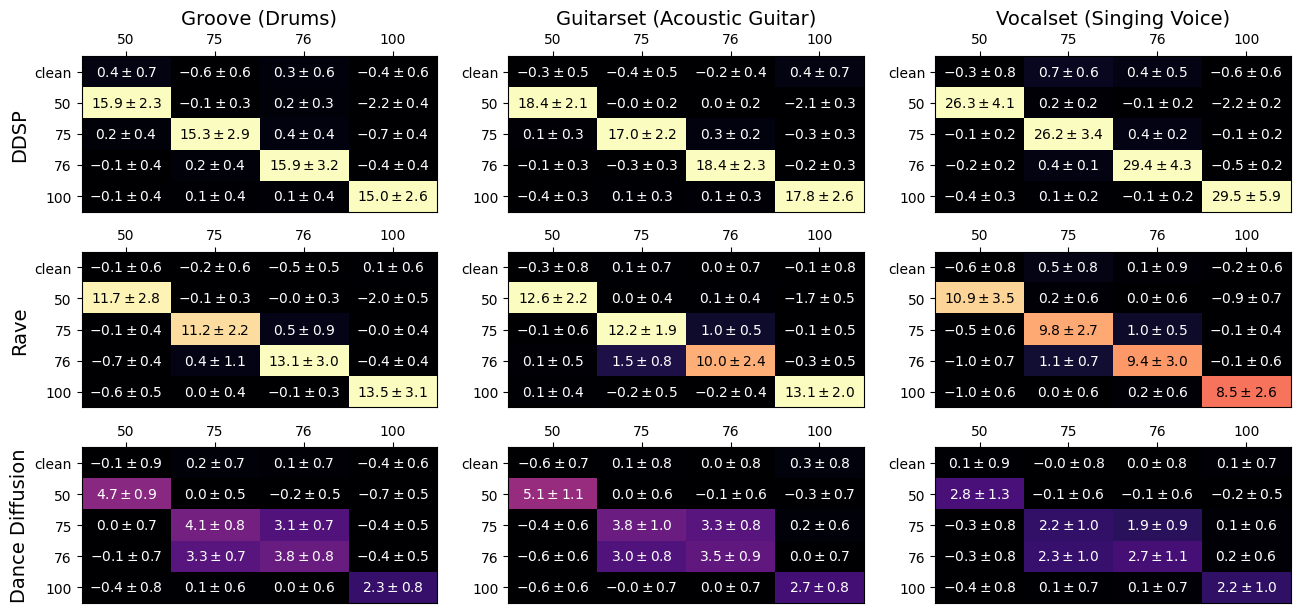

In [13]:
fac = 1.2
plt.figure(figsize=(fac*13, fac*6))
dur = 5
instruments = ["drums", "other", "vocals"]
titles = {"drums":"Groove (Drums)", "other":"Guitarset (Acoustic Guitar)", "vocals":"Vocalset (Singing Voice)"}
idx = 1
vmin = 0
vmax = 12
for row, (results, model) in enumerate(zip([results_ddsp, results_rave, results_dd], ["DDSP", "Rave", "Dance Diffusion"])):
    for col, instrument in enumerate(instruments):
        plt.subplot(3, len(instruments), idx)
        D = np.zeros((len(echoes), len(echoes)-1))
        S = np.zeros((len(echoes), len(echoes)-1))
        for i, dataset in enumerate(echoes):
            for j, echo in enumerate(echoes[1:]):
                zs = results[instrument][dur][dataset][echo]
                mu = np.mean(zs)
                std = np.std(zs)
                D[i, j] = mu
                S[i, j] = std
        plt.imshow(D, aspect=0.35, cmap='magma', interpolation='none', vmin=vmin, vmax=vmax)
        plt.yticks(np.arange(len(echoes)), echoes)
        plt.gca().tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
        plt.xticks(np.arange(len(echoes)-1), echoes[1:])
        for i in range(D.shape[0]):
            for j in range(D.shape[1]):
                color = 'white'
                if D[i, j] > vmin + 0.6*(vmax-vmin):
                    color = 'black'
                plt.text(j, i, "${:.1f} \\pm {:.1f}$".format(D[i, j], S[i, j]), color=color, horizontalalignment='center', verticalalignment='center')
        if row == 0:
            plt.title(titles[instrument], fontsize=14)
        if col == 0:
            plt.ylabel(model, fontsize=14)
        idx += 1
plt.savefig("../Writeup/figs/AllSingleEchoZScores.svg", bbox_inches='tight')